## Day - 3 The Congressional Voting Records (1984)

#### Understanding the Dataset:
The Congressional Voting Records datase from 1984 contains voting records for U.S. House of representatives congressmen. the task here is to predict the party affiliation based on their votes on various issues.

In [2]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [4]:
# seeding for reproducibility
np.random.seed(42)

#### Loading Dataset

In [5]:
columns = ['party', 'handicapped-infants', 'water-project-cost-sharing', 
           'adoption-of-the-budget-resolution', 'physician-fee-freeze',
           'el-salvador-aid', 'religious-groups-in-schools',
           'anti-satellite-test-ban', 'aid-to-nicaraguan-contras',
           'mx-missile', 'immigration', 'synfuels-corporation-cutback',
           'education-spending', 'superfund-right-to-sue', 'crime',
           'duty-free-exports', 'export-administration-act-south-africa']


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"
df = pd.read_csv(url, names=columns)

Dataset shape: (435, 17)
        party handicapped-infants water-project-cost-sharing  \
0  republican                   n                          y   
1  republican                   n                          y   
2    democrat                   ?                          y   
3    democrat                   n                          y   
4    democrat                   y                          y   

  adoption-of-the-budget-resolution physician-fee-freeze el-salvador-aid  \
0                                 n                    y               y   
1                                 n                    y               y   
2                                 y                    ?               y   
3                                 y                    n               ?   
4                                 y                    n               y   

  religious-groups-in-schools anti-satellite-test-ban  \
0                           y                       n   
1                  

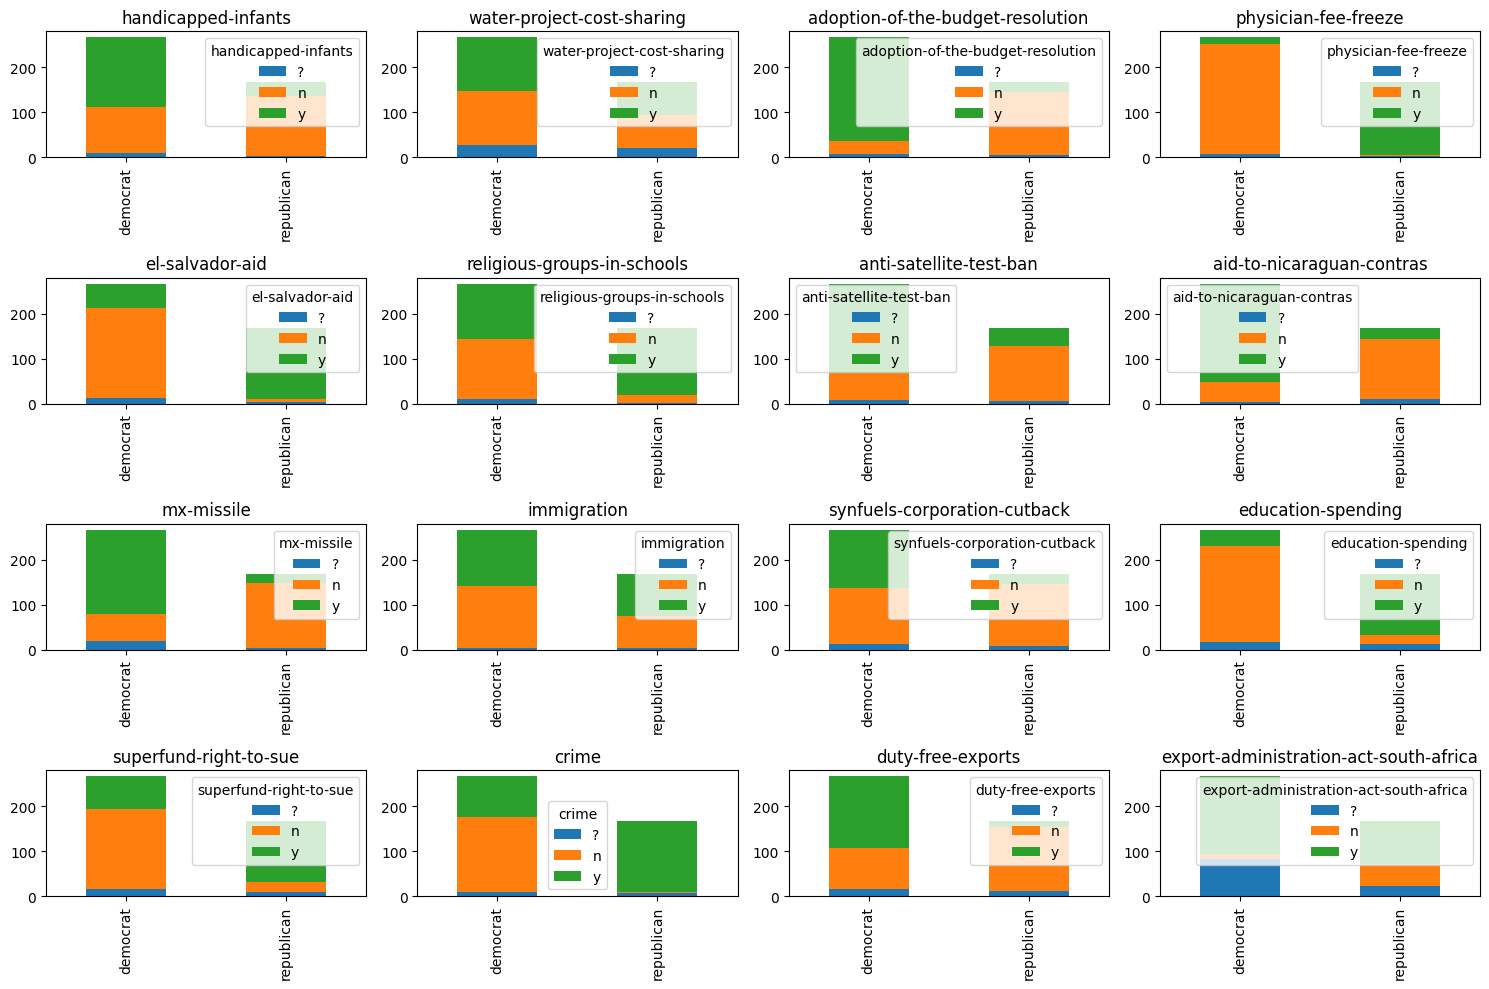

In [6]:
print("Dataset shape:", df.shape)
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nClass distribution:")
print(df['party'].value_counts())

df_encoded = df.replace({'y': 1, 'n': 0, '?': -1})
print("\nBasic statistics:")
print(df_encoded.describe())

plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[1:]):
    plt.subplot(4, 4, i+1)
    df_pivot = pd.crosstab(df['party'], df[column])
    df_pivot.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(column)
    plt.xlabel('')
    if i % 4 != 0:
        plt.ylabel('')
plt.tight_layout()
plt.show()

In this dataset, we have votes represented as 'y' (yes), 'n' (no), and '?' (unknown). We need to handle by replacing the "?" -> with the most common vote for that party

In [7]:
for column in df.columns[1:]:
    for party in ['democrat', 'republican']:
        party_votes = df[df['party'] == party][column]
        most_common = party_votes[party_votes != '?'].mode()[0]
        mask = (df['party'] == party) & (df[column] == '?')
        df.loc[mask, column] = most_common

le = LabelEncoder()
X = df.iloc[:, 1:].apply(le.fit_transform)
y = le.fit_transform(df['party'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (348, 16)
Testing set shape: (87, 16)


### Training the Model

Logistic Regression: 0.9683 ± 0.0142
Random Forest: 0.9597 ± 0.0170
SVM: 0.9626 ± 0.0147
KNN: 0.9396 ± 0.0169
Naive Bayes: 0.9454 ± 0.0109


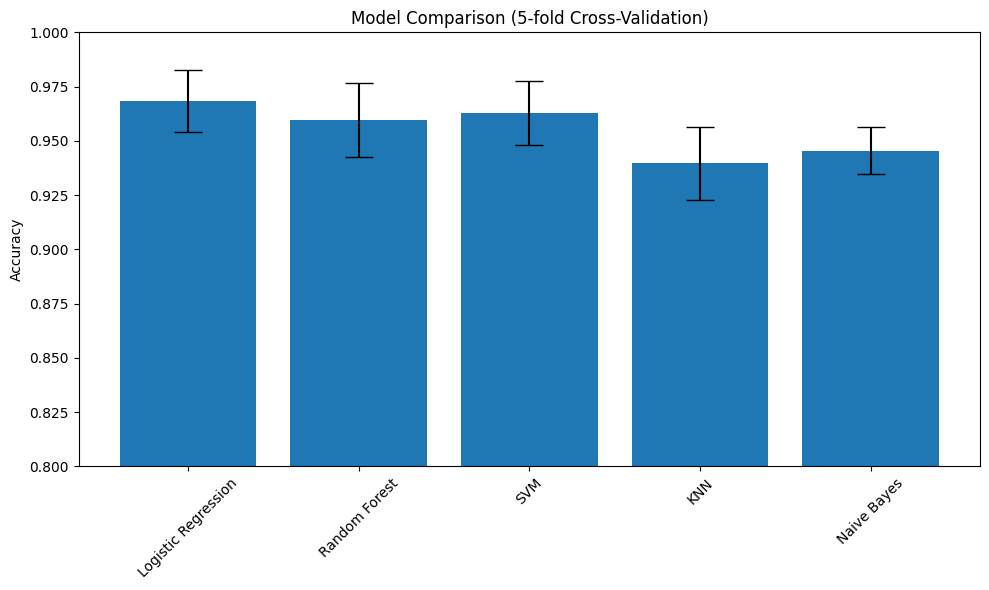

In [8]:
# For selecting the best model, we will use cross-validation

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    print(f"{name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

plt.figure(figsize=(10, 6))
names = list(results.keys())
cv_means = [results[name]['cv_mean'] for name in names]
cv_stds = [results[name]['cv_std'] for name in names]

plt.bar(names, cv_means, yerr=cv_stds, capsize=10)
plt.title('Model Comparison (5-fold Cross-Validation)')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Since, Logistic regression performed best in inital eval, we will be doing hyperparameter tuning for logistic regression.

In [9]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000],
    'class_weight': [None, 'balanced']
}

log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

best_lr = grid_search.best_estimator_

/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

Best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9712


/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

#### The Theory Behind Logistic Regression Parameters

*C*: This is the inverse of regularization strength. Smaller values specify stronger regularization, which helps prevent overfitting. For a political dataset with relatively few features, we want to find the sweet spot between model flexibility and generalization.

*penalty*: The 'l1' penalty (Lasso) can lead to feature selection by setting some coefficients to zero, while 'l2' (Ridge) shrinks coefficients toward zero but not exactly to zero. L1 is useful when we suspect only a subset of votes highly indicate party affiliation.

*solver*: Different optimization algorithms for the logistic regression objective function. 'liblinear' works well for small datasets, while 'saga' supports both L1 and L2 regularization and is efficient for larger datasets.

*class_weight*: Setting this to 'balanced' adjusts weights inversely proportional to class frequencies, which helps if there's a class imbalance between Democrats and Republicans in the dataset.

##### Note: 

For Logistic Regression the default value of C = 1, which may or may not be optimal. Too small C values can underfit, while large values can overfit. 

##### Suggestion:
Performing a grid search across multiple orders of magnitude of C values.

Test Accuracy: 0.9770

Classification Report:
              precision    recall  f1-score   support

    Democrat       0.98      0.98      0.98        56
  Republican       0.97      0.97      0.97        31

    accuracy                           0.98        87
   macro avg       0.97      0.97      0.97        87
weighted avg       0.98      0.98      0.98        87



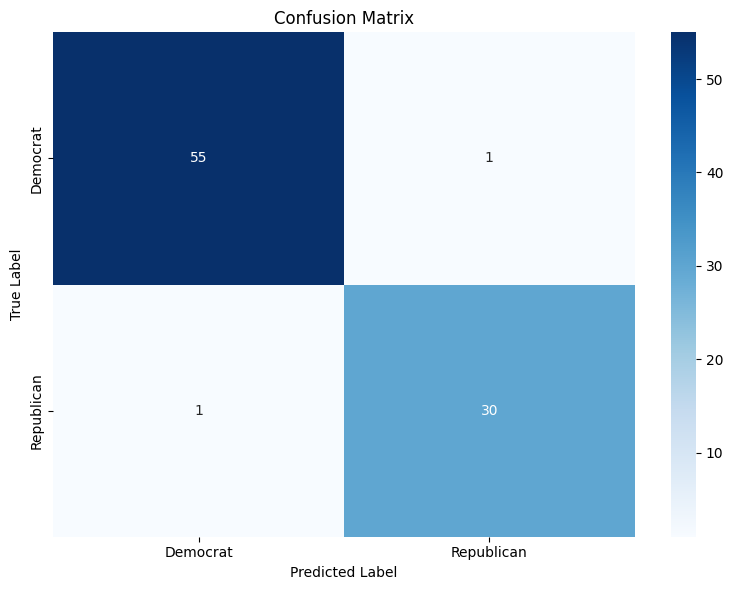

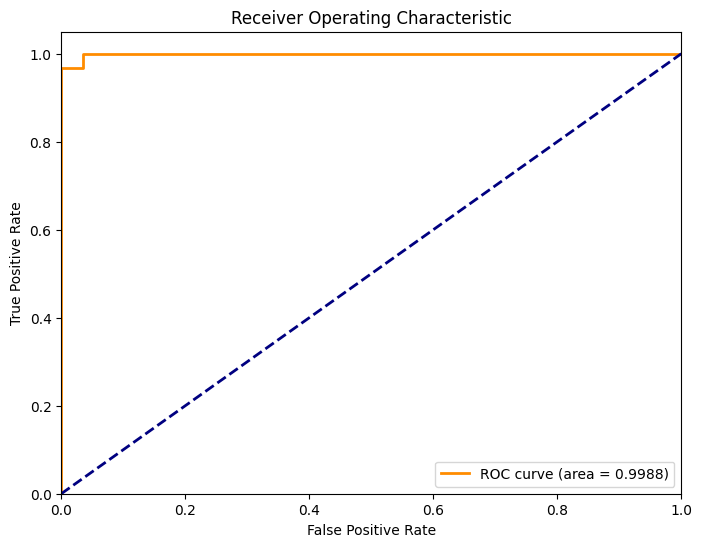

In [10]:
# model evalution

y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]  # Probability of being Republican
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Democrat', 'Republican']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Democrat', 'Republican'],
            yticklabels=['Democrat', 'Republican'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

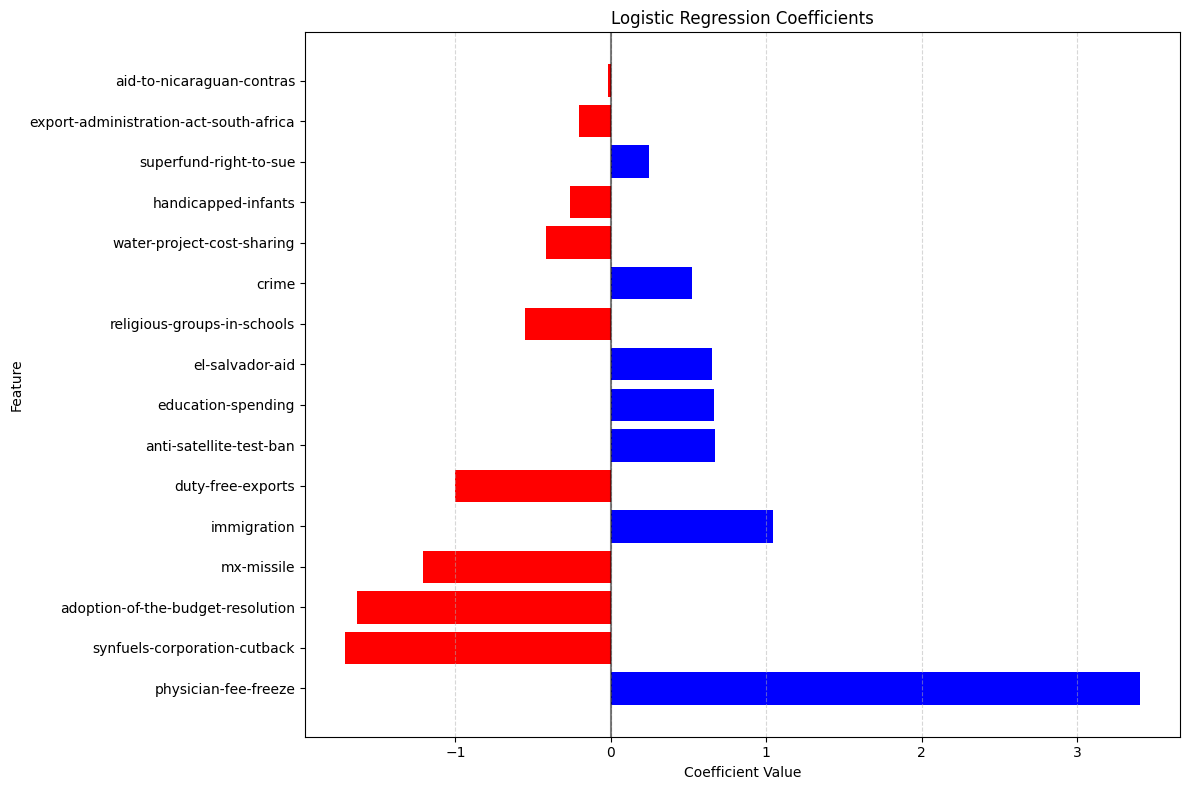

Top 5 most influential votes:
                              Feature  Coefficient  Abs_Coefficient
3                physician-fee-freeze     3.405954         3.405954
10       synfuels-corporation-cutback    -1.712203         1.712203
2   adoption-of-the-budget-resolution    -1.635678         1.635678
8                          mx-missile    -1.207174         1.207174
9                         immigration     1.041618         1.041618


In [11]:
coefficients = pd.DataFrame({
    'Feature': df.columns[1:],  
    'Coefficient': best_lr.coef_[0]
})

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(y=coefficients['Feature'], width=coefficients['Coefficient'], color=['red' if c < 0 else 'blue' for c in coefficients['Coefficient']])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Top 5 most influential votes:")
print(coefficients.head(5))

Unlike tree-based models, Logistic regression assigns coefficients to features which means it can be directly interpreted as the log odds contribution of each feature

The magnitude of the coefficient indicates the strength of the association between that vote and party affiliation.

As, the coeddicients are log-odds, not probabilities. To get probability changes we need to tranform using the logistic funtion.

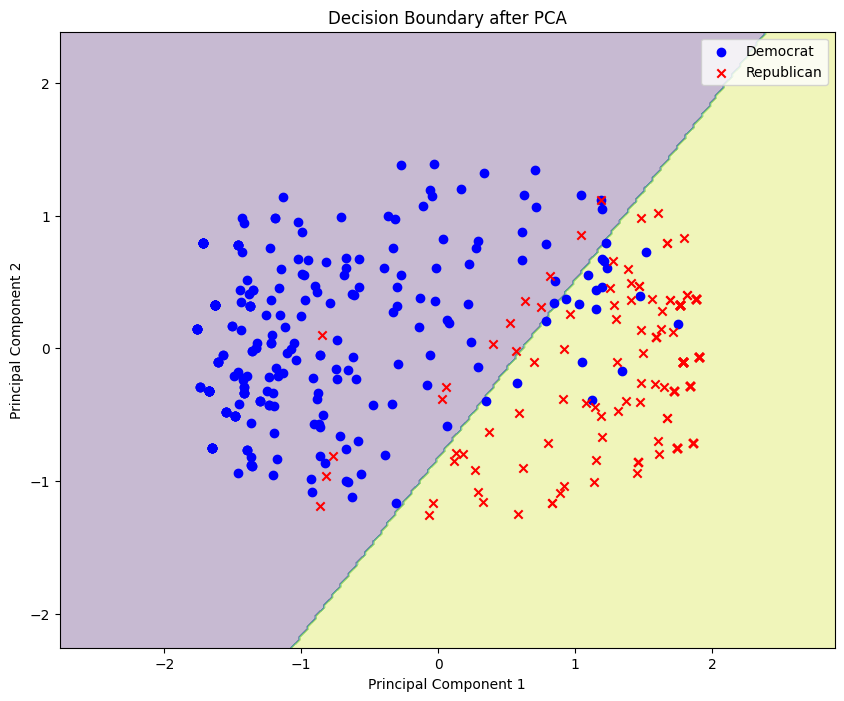

Accuracy after PCA: 0.8966

PCA Component Analysis:
Top contributors to PC1:
el-salvador-aid              0.329133
aid-to-nicaraguan-contras   -0.319455
physician-fee-freeze         0.309605
mx-missile                  -0.301164
education-spending           0.296375
Name: PC1, dtype: float64

Top contributors to PC2:
water-project-cost-sharing      0.648851
synfuels-corporation-cutback    0.462768
immigration                    -0.431743
anti-satellite-test-ban        -0.192116
handicapped-infants             0.188826
Name: PC2, dtype: float64


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

lr_pca = LogisticRegression(max_iter=1000, random_state=42)
lr_pca.fit(X_train_pca, y_train)
h = 0.02  
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='blue', marker='o', label='Democrat')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='red', marker='x', label='Republican')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary after PCA')
plt.legend()
plt.show()

accuracy_pca = lr_pca.score(X_test_pca, y_test)
print(f"Accuracy after PCA: {accuracy_pca:.4f}")

print("\nPCA Component Analysis:")
component_df = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(2)],
    index=df.columns[1:]
)
print("Top contributors to PC1:")
print(component_df.sort_values(by='PC1', key=abs, ascending=False)['PC1'].head(5))
print("\nTop contributors to PC2:")
print(component_df.sort_values(by='PC2', key=abs, ascending=False)['PC2'].head(5))

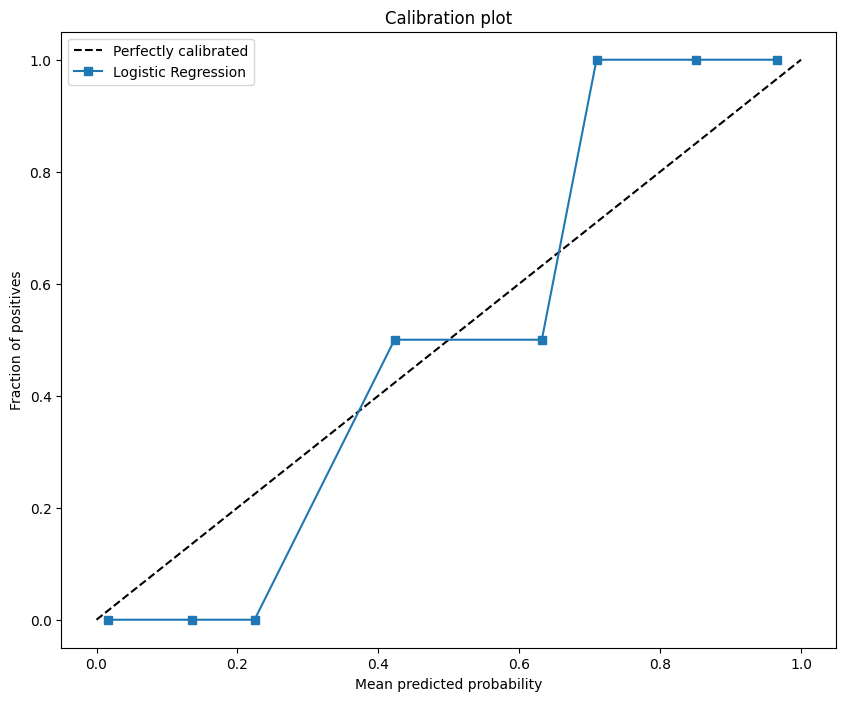

In [14]:
from sklearn.calibration import calibration_curve
# Creating a calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Logistic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.show()

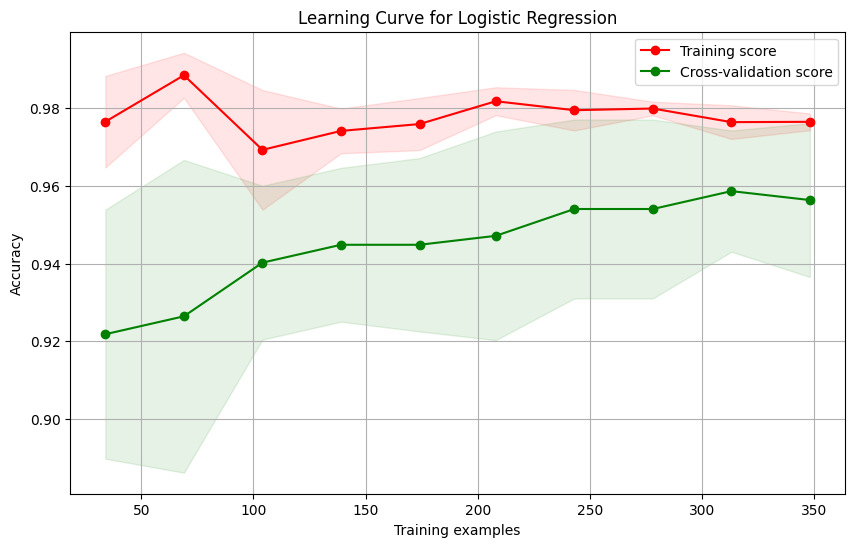

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_lr, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Logistic Regression")
plt.legend(loc="best")
plt.grid()
plt.show()

Political Context analysis

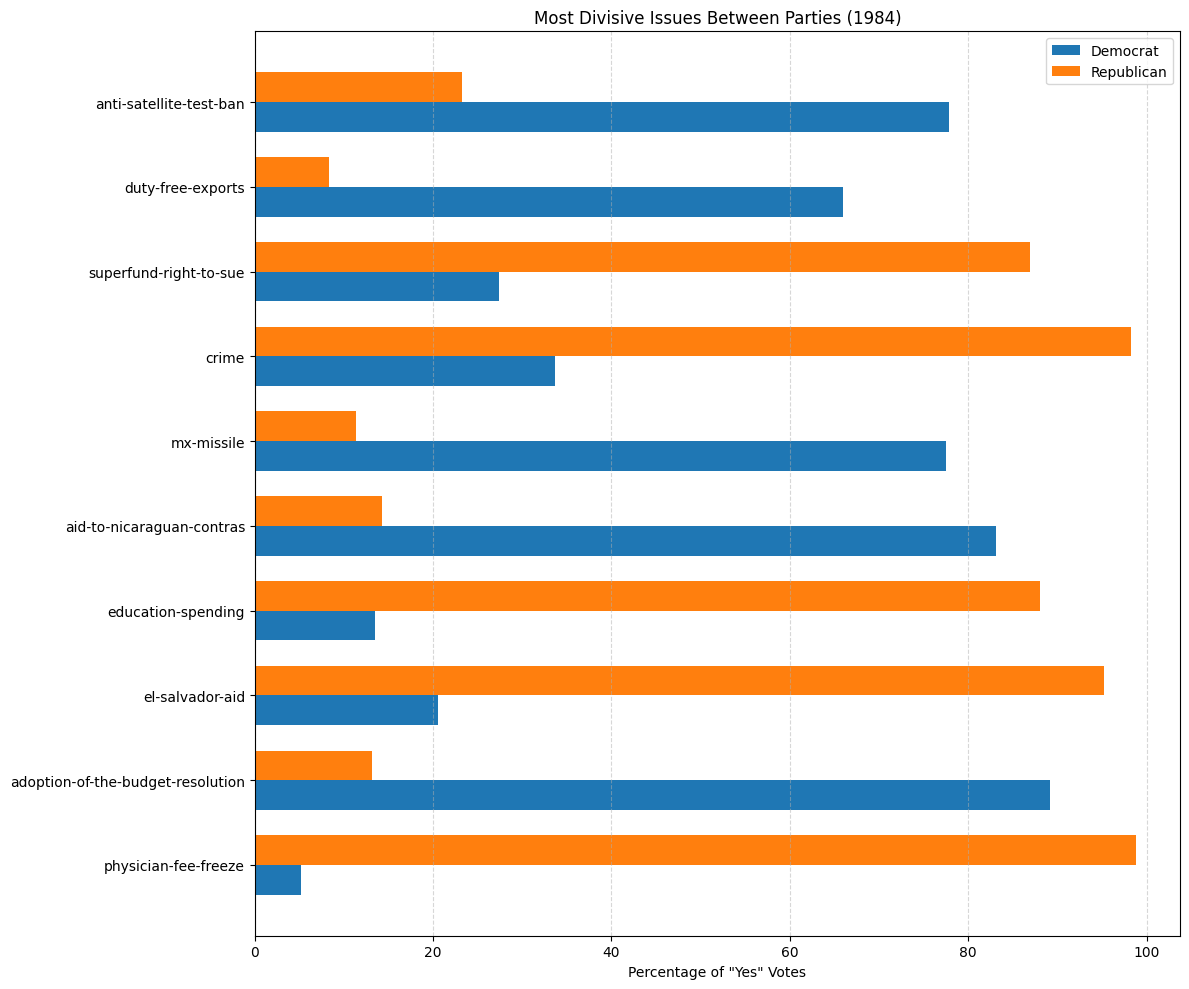

Most divisive issues:
                                Issue  Democrat_Yes%  Republican_Yes%  \
3                physician-fee-freeze       5.243446        98.809524   
2   adoption-of-the-budget-resolution      89.138577        13.095238   
4                     el-salvador-aid      20.599251        95.238095   
11                 education-spending      13.483146        88.095238   
7           aid-to-nicaraguan-contras      83.146067        14.285714   
8                          mx-missile      77.528090        11.309524   
13                              crime      33.707865        98.214286   
12             superfund-right-to-sue      27.340824        86.904762   
14                  duty-free-exports      65.917603         8.333333   
6             anti-satellite-test-ban      77.902622        23.214286   

    Difference  
3    93.566078  
2    76.043339  
4    74.638844  
11   74.612092  
7    68.860353  
8    66.218566  
13   64.506421  
12   59.563938  
14   57.584270  
6   

In [ ]:
vote_patterns = []

for column in df.columns[1:]:
    dem_yes = df[(df['party'] == 'democrat') & (df[column] == 'y')].shape[0] / df[df['party'] == 'democrat'].shape[0]
    rep_yes = df[(df['party'] == 'republican') & (df[column] == 'y')].shape[0] / df[df['party'] == 'republican'].shape[0]
    
    vote_patterns.append({
        'Issue': column,
        'Democrat_Yes%': dem_yes * 100,
        'Republican_Yes%': rep_yes * 100,
        'Difference': abs(dem_yes - rep_yes) * 100
    })

vote_patterns = pd.DataFrame(vote_patterns)
vote_patterns = vote_patterns.sort_values('Difference', ascending=False)

plt.figure(figsize=(12, 10))
top_issues = vote_patterns.head(10)
x = np.arange(len(top_issues))
width = 0.35

plt.barh(x - width/2, top_issues['Democrat_Yes%'], width, label='Democrat')
plt.barh(x + width/2, top_issues['Republican_Yes%'], width, label='Republican')

plt.yticks(x, top_issues['Issue'])
plt.xlabel('Percentage of "Yes" Votes')
plt.title('Most Divisive Issues Between Parties (1984)')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Most divisive issues:")
print(top_issues[['Issue', 'Democrat_Yes%', 'Republican_Yes%', 'Difference']])

In [20]:
import joblib
joblib.dump(best_lr, 'congressional_voting_lr_classifier.pkl')

def preprocess_votes(votes_dict):
    processed_votes = []
    
    for column in df.columns[1:]:
        if column in votes_dict:
            vote = votes_dict[column]
            if vote == '?':
                vote = 'n'  # Default imputation for simplicity
            processed_votes.append(1 if vote == 'y' else 0)
        else:
            processed_votes.append(0)  # Default if missing
            
    return np.array(processed_votes).reshape(1, -1)

def predict_party_with_reasoning(votes_dict):
    processed_votes = preprocess_votes(votes_dict)
    party_pred = best_lr.predict(processed_votes)[0]
    party_prob = best_lr.predict_proba(processed_votes)[0]
    
    predicted_party = 'democrat' if party_pred == 0 else 'republican'
    confidence = party_prob[party_pred] * 100
    explanation = []
    coefs = best_lr.coef_[0]
    features = df.columns[1:]
    contributions = []
    for i, feature in enumerate(features):
        if feature in votes_dict:
            vote_value = 1 if votes_dict[feature] == 'y' else 0
            contribution = coefs[i] * vote_value
            contributions.append((feature, contribution, votes_dict[feature]))

    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    for feature, contribution, vote in contributions[:3]:
        if contribution > 0:
            direction = "Republican" 
        else:
            direction = "Democrat"
            
        explanation.append(f"Vote '{vote}' on '{feature}' contributed toward {direction} classification (weight: {abs(contribution):.4f})")
    
    return predicted_party, confidence, explanation

In [21]:
# Example

new_congressman = {
    'handicapped-infants': 'y',
    'water-project-cost-sharing': 'n',
    'adoption-of-the-budget-resolution': 'n',
    'physician-fee-freeze': 'y',
    'el-salvador-aid': 'y',
    'religious-groups-in-schools': 'y',
    'anti-satellite-test-ban': 'n',
    'aid-to-nicaraguan-contras': 'y',
    'mx-missile': 'y',
    'immigration': 'n'
}

predicted_party, confidence, explanation = predict_party_with_reasoning(new_congressman)
print(f"Predicted party: {predicted_party} (confidence: {confidence:.2f}%)")
print("\nExplanation:")
for point in explanation:
    print(f"- {point}")

Predicted party: republican (confidence: 73.06%)

Explanation:
- Vote 'y' on 'physician-fee-freeze' contributed toward Republican classification (weight: 3.4060)
- Vote 'y' on 'mx-missile' contributed toward Democrat classification (weight: 1.2072)
- Vote 'y' on 'el-salvador-aid' contributed toward Republican classification (weight: 0.6531)


Logistic Regression Test Accuracy: 0.8966
SVM Test Accuracy: 0.8966
Random Forest Test Accuracy: 0.9310
Naive Bayes Test Accuracy: 0.8851


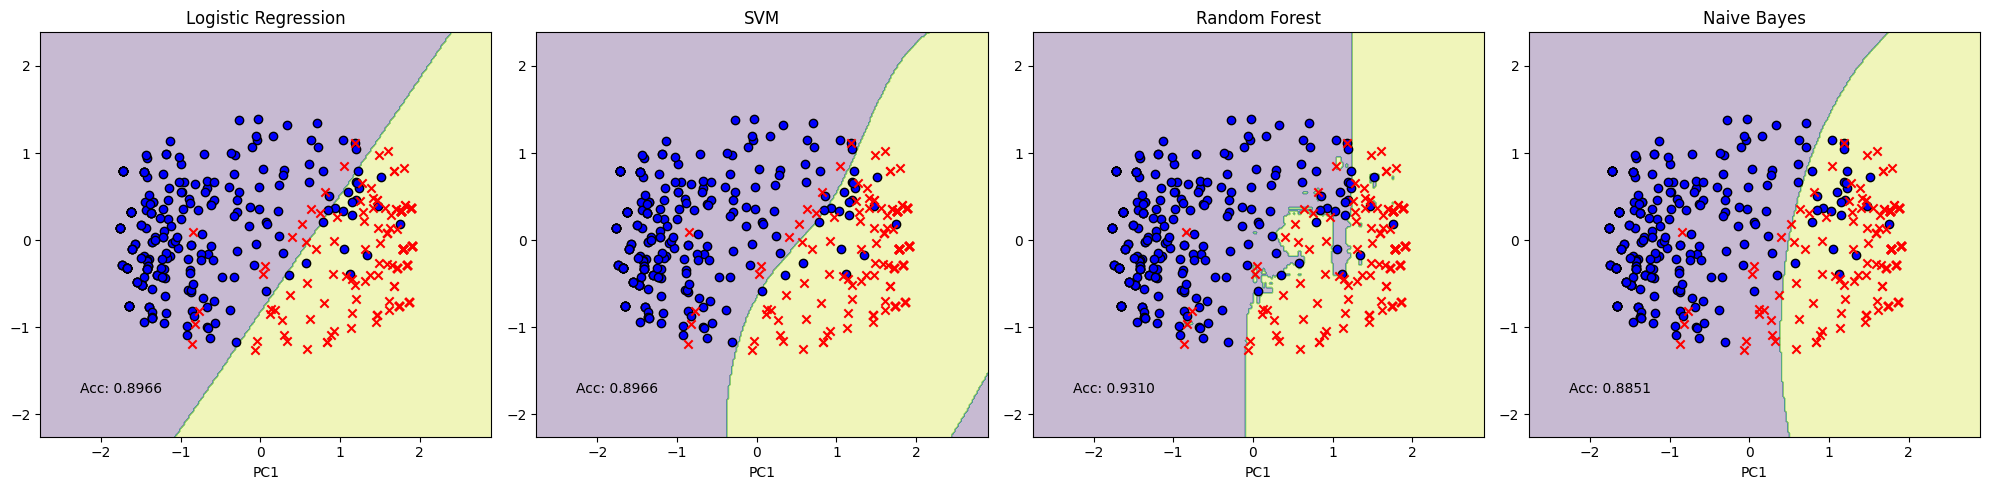

In [23]:
# Comparing decision boundaries of different models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
plt.figure(figsize=(20, 5))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_pca, y_train)
    plt.subplot(1, 4, i+1)
    h = 0.02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='blue', marker='o', edgecolors='k', label='Democrat')
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='red', marker='x', edgecolors='k', label='Republican')
    plt.title(name)
    plt.xlabel('PC1')
    accuracy = model.score(X_test_pca, y_test)
    print (f"{name} Test Accuracy: {accuracy:.4f}")
    plt.text(x_min + 0.5, y_min + 0.5, f"Acc: {accuracy:.4f}", fontsize=10)

plt.tight_layout()
plt.show()

Now, let's see using Random forest as it's accuracy is 0.9310

In [24]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
best_rf = grid_search.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.9684


Test Accuracy: 0.9770

Classification Report:
              precision    recall  f1-score   support

    Democrat       0.98      0.98      0.98        56
  Republican       0.97      0.97      0.97        31

    accuracy                           0.98        87
   macro avg       0.97      0.97      0.97        87
weighted avg       0.98      0.98      0.98        87



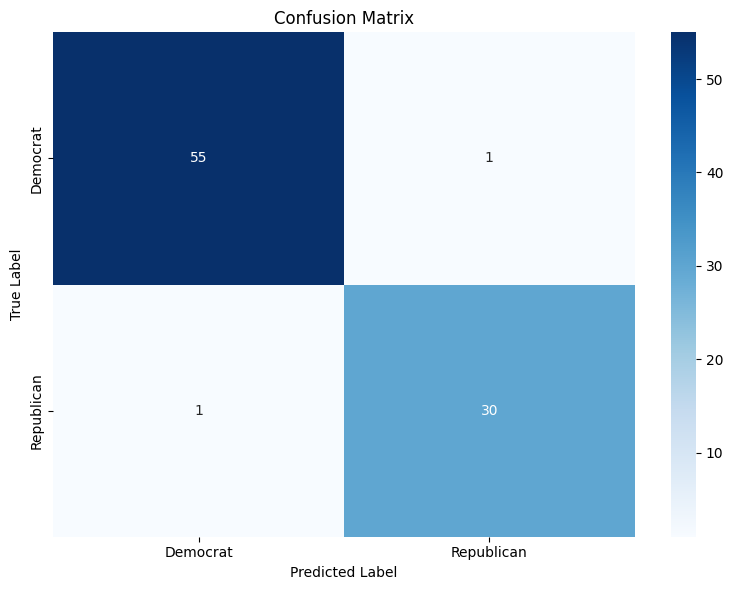

In [25]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Democrat', 'Republican']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Democrat', 'Republican'],
            yticklabels=['Democrat', 'Republican'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

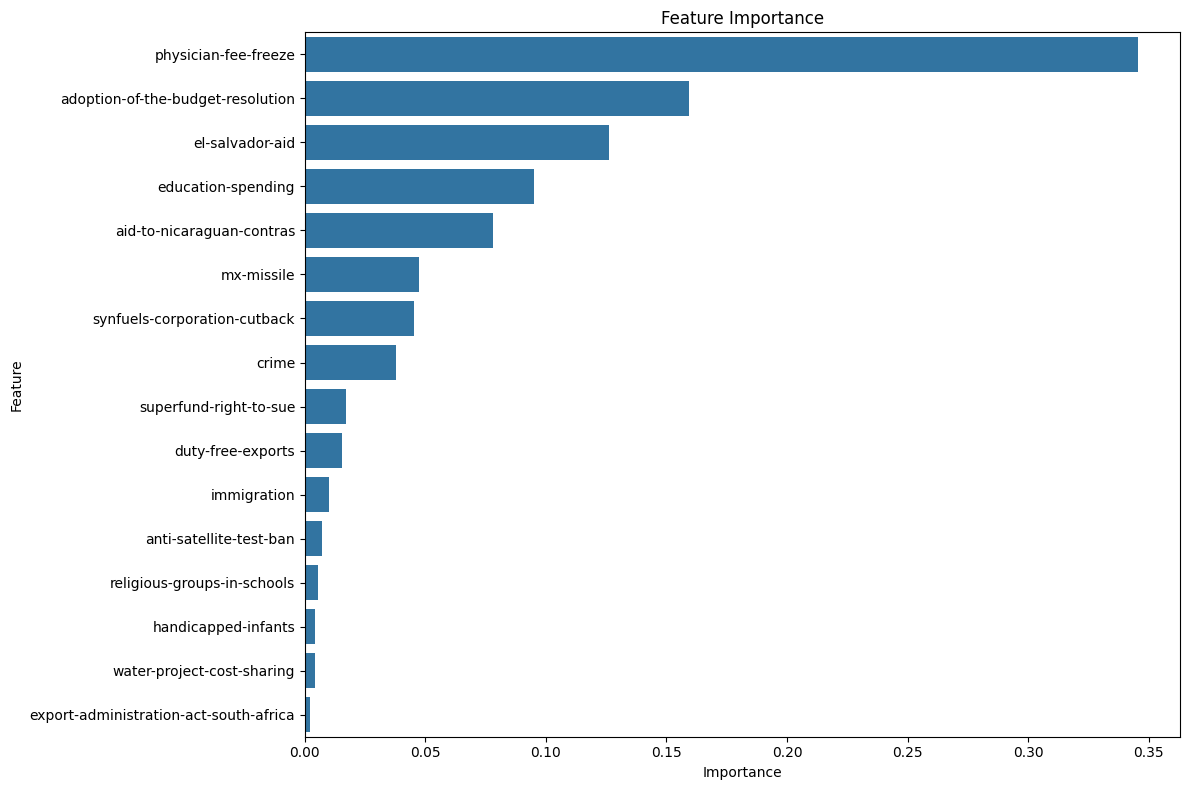

Top 5 most predictive votes:
                              Feature  Importance
3                physician-fee-freeze    0.345729
2   adoption-of-the-budget-resolution    0.159225
4                     el-salvador-aid    0.126227
11                 education-spending    0.095121
7           aid-to-nicaraguan-contras    0.078005


In [26]:
feature_importance = pd.DataFrame({
    'Feature': df.columns[1:],
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 5 most predictive votes:")
print(feature_importance.head(5))

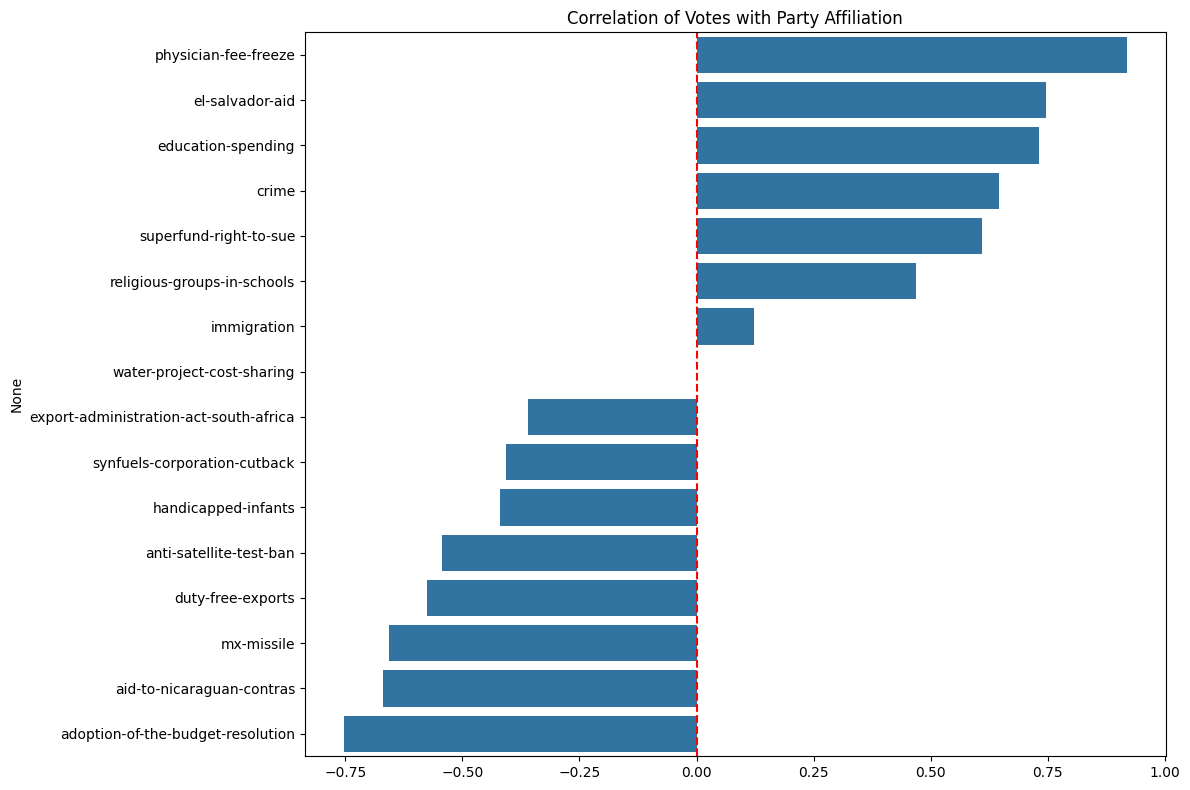

In [27]:
corr_matrix = pd.DataFrame(np.corrcoef(X_train.T), 
                         columns=df.columns[1:], 
                         index=df.columns[1:])

party_corr = []
for col in X_train.columns:
    corr = np.corrcoef(X_train[col], y_train)[0, 1]
    party_corr.append(corr)

party_corrs = pd.Series(party_corr, index=df.columns[1:])
party_corrs = party_corrs.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=party_corrs.values, y=party_corrs.index)
plt.title('Correlation of Votes with Party Affiliation')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [30]:
import joblib
joblib.dump(best_rf, 'congressional_voting_rf_classifier.pkl')

def predict_party(votes_dict):
    votes = []
    for col in df.columns[1:]:
        if col in votes_dict:
            vote = votes_dict[col]
            if vote == '?':
                vote = 'n'  # Placeholder
            votes.append(1 if vote == 'y' else 0)
        else:
            votes.append(0)  # Default to 'n' if issue is not provided

    votes_array = np.array(votes).reshape(1, -1)
    prediction = best_rf.predict(votes_array)[0]
    
    return 'democrat' if prediction == 0 else 'republican'

In [31]:
# Example

new_congressman = {
    'handicapped-infants': 'y',
    'water-project-cost-sharing': 'y',
    'adoption-of-the-budget-resolution': 'n',
    'physician-fee-freeze': 'y',
    'el-salvador-aid': 'y',
    # ... other votes
}

predicted_party = predict_party(new_congressman)
print(f"Predicted party: {predicted_party}")

Predicted party: republican
